<a href="https://colab.research.google.com/github/regiltcj/upwork-investx/blob/version-0/upwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Objective**
To identify the brands with growth potential from those selling on amazon so that they could be supported with sufficient credits
## **Requirement**
Create a heuristic model that can be used to rank the brands based on the growth potential that in turn indicates their credit worthiness
## **KPIs under consideration**
1. Time series
2. Periodic metrics
3. Snapshot metrics (Sellers/Brand relations)



#### Importing required libraries

In [ ]:
from glob import glob
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as sc
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount("/content/drive")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


#### Reading the dataset

In [ ]:
source_path = "/content/drive/MyDrive/upwork/dataset/"

brand_competitors = pd.read_csv(source_path + "bi_brand_competitors.csv")
brand_metrics_daily = pd.read_csv(source_path + "bi_brand_metrics_daily.csv")
brand_metrics_period = pd.read_csv(source_path + "bi_brand_metrics_period.csv")
brand_metrics_snapshot = pd.read_csv(source_path + "bi_brand_metrics_snapshot.csv")
brand_segmentation = pd.read_csv(source_path + "bi_brand_segmentation.csv")
brand_sellers = pd.read_csv(source_path + "bi_brand_sellers.csv")
product_sales_ranks_log = pd.read_csv(source_path + "product_sales_ranks_log.csv")
products = pd.read_csv(source_path + "products.csv")
product_snapshots = pd.read_csv(source_path + "product_snapshots.csv")
product_metrics_daily = pd.read_csv(source_path + "product_metrics_daily.csv")

In [ ]:
print("brand_competitors: {}".format(brand_competitors.shape))
print("brand_metrics_daily: {}".format(brand_metrics_daily.shape))
print("brand_metrics_period: {}".format(brand_metrics_period.shape))
print("brand_metrics_snapshot: {}".format(brand_metrics_snapshot.shape))
print("brand_segmentation: {}".format(brand_segmentation.shape))
print("brand_sellers: {}".format(brand_sellers.shape))
print("product_sales_ranks_log: {}".format(product_sales_ranks_log.shape))
print("products: {}".format(products.shape))
print("product_snapshots: {}".format(product_snapshots.shape))
print("product_metrics_daily: {}".format(product_metrics_daily.shape))

brand_competitors: (331255, 8)
brand_metrics_daily: (664535, 11)
brand_metrics_period: (4108, 2)
brand_metrics_snapshot: (4116, 17)
brand_segmentation: (3995, 28)
brand_sellers: (31697, 6)
product_sales_ranks_log: (7767300, 5)
products: (22922, 14)
product_snapshots: (22922, 20)
product_metrics_daily: (1851006, 9)


In [ ]:
# Checking the number of distinct brands from the 'products' table
products["brand"].nunique()

4125

i.e. We need to create a scoring mechanism the provides scores to each of the 4125 brands and could be used to find the low risk brands for investing

### ***Time Series***
In this list of KPIs, we analyse the trends in the time series data and each of the time serires will be translated to a score (this will be per brand per category). A weighted average (weighted based on the revenue of each category) of the above score across category will provide the score for the brand. 

---
**KPIs**
  1. Sales/share
  2. Items/share
  3. Reviews (count/score)
  4. Competition level
  5. Pricing
  6. Number of Products
---
**Tasks**
 - General
   1. Brainstorm on how to quantify the trend of a time series data<br>
   Proposed solution - 
    - Find the growth rate for the entire time frame and use that itself as a score (or a standardized value as score)
    
    - Find the weekly growth rate and find the slope of the line that fits the weekly growth rate. (Zero slope means constant growth rate, negative means declining growth rate and positive means increasing growth rate)

    - Create a column that represent the fraction of weeks the sales were growing 

    - Create a column that represent the trend in the latest week (-1, 0, 1)

    - Isolate the trend from the time series and Find the statistical strength of the trend

   2. Calculate the weights for each category of the brand

 - Specfic to metric
   1. Identify the tables from which the data can be pulled
   2. Collect the data and create the dataset
   3. Quantify the trend for the brand, category combination
   4. Perform weighted average (based on the revenue for each category) across category to arrive at the score for brand 
---

**Discussion Points**

- Filter out those brands that does not have sufficient number of positive values rather than ust looking at the data.<br>
The 76 days can contain 0's and hnce by removing those does not have suffiient positive sales we can remove those outliers/sudden spikes at this stage itself
- From the remaining set we have to find the min_no_of_sample_dates acccordingly (from 76) -- This won't be neccessary since it would already be filered out

Have to rethink on the below point
- Half of the min_no_of_sample_dates days has to be positive

##### **Sales share**
This represents the total sales revenue(from all the different products) of a brand and category as a fraction of total sales revenue in that particular category for a given date

**Analysis**

In [ ]:
# 'brand_metrics_daily' table has the daily on the total revenue obtained by the brand in a specific category as a fraction of total revenue of the category 
# Above info is available from the date from which a brand starts selling a product in a particular leaf category
brand_metrics_daily.head()

,brand,category_id,sample_date,products,avg_sales_rank,avg_reviews_score,avg_reviews_count,daily_items,daily_items_share,daily_sales,daily_sales_share
0,Cambridge,490757011,2021-08-27,1,123193.000,4.5,38.0,1.066567,0.000105,42.033392,0.000239
1,Cambridge,490757011,2021-08-28,1,139747.000,4.5,38.0,0.934267,0.000099,36.819449,0.000230
2,Cambridge,490757011,2021-08-29,1,148252.375,4.5,38.0,0.878267,0.000089,34.612489,0.000212
3,Cambridge,490757011,2021-08-30,1,157976.000,4.5,38.0,0.821567,0.000084,32.377942,0.000203
4,Cambridge,490757011,2021-08-31,1,168288.750,4.5,38.0,0.768833,0.000079,30.299722,0.000188


In [ ]:
print("Fileds of 'brand_metrics_daily'")
cols = brand_metrics_daily.columns
for i, col in enumerate(cols):
  print(f"{i} \t {col}")
print(f"\nNumber of distinct brands in 'brand_metrics_daily': {brand_metrics_daily['brand'].nunique()}")
print(f"Number of distinct brand-category combination in 'brand_metrics_daily': {brand_metrics_daily.drop_duplicates(subset=['brand', 'category_id']).shape[0]}")

Fileds of 'brand_metrics_daily'
0 	 brand
1 	 category_id
2 	 sample_date
3 	 products
4 	 avg_sales_rank
5 	 avg_reviews_score
6 	 avg_reviews_count
7 	 daily_items
8 	 daily_items_share
9 	 daily_sales
10 	 daily_sales_share

Number of distinct brands in 'brand_metrics_daily': 4005
Number of distinct brand-category combination in 'brand_metrics_daily': 7782


In [ ]:
# Converting the 'sample_date' to datetime field
brand_metrics_daily["sample_date"] = pd.to_datetime(brand_metrics_daily["sample_date"])

In [ ]:
# Finding the minimum and maximum sample date in the whole dataset
print(f"Minimum date: {brand_metrics_daily['sample_date'].min()}")
print(f"Maximum date: {brand_metrics_daily['sample_date'].max()}")

Minimum date: 2021-08-27 00:00:00
Maximum date: 2021-11-24 00:00:00


In [ ]:
# Checking if the min and max date is the same for all brand, category combination.
num_min_sample_dates = brand_metrics_daily.groupby(by=["brand", "category_id"]).min()["sample_date"].nunique()
num_max_sample_dates = brand_metrics_daily.groupby(by=["brand", "category_id"]).max()["sample_date"].nunique()
print(f"Number of distinct starting sample date: {num_min_sample_dates}")
print(f"Number of distinct ending sample date: {num_max_sample_dates}")
print("Number of brand, category combination present for each of the distinct end date")
print(brand_metrics_daily.groupby(by=["brand", "category_id"]).max()["sample_date"].value_counts())

# Different brand-category combinations have different start date and end date
# i.e We have the data till 2021-11-23 for 3981 brands-category combination while we have data only till 22-11-2021 for 3514. For 287 brand-category combinations we have data till 2021-11-24

Number of distinct starting sample date: 85
Number of distinct ending sample date: 3
Number of brand, category combination present for each of the distinct end date
2021-11-23    3981
2021-11-22    3514
2021-11-24     287
Name: sample_date, dtype: int64


In [ ]:
brand_category_days_cumsum = brand_metrics_daily.groupby(by=["brand", "category_id"]).count()["sample_date"].value_counts().sort_index(ascending=False).cumsum()
print(brand_category_days_cumsum.head())
print(brand_category_days_cumsum.tail())
# Below cumulative sum table indicate the number of brands for which we have that many number of day's data
# Note: cumulative sum table means the final sum would be total number of brand-categories combination (7782)

90      13
89     462
88    7325
87    7330
86    7333
Name: sample_date, dtype: int64
5    7762
4    7766
3    7771
2    7781
1    7782
Name: sample_date, dtype: int64


In [ ]:
# Finding the number of days for which we have data for 95% of brand-categories
print("Numbr of days for which the we have data for 95% of brand-categories")
brand_category_days_cumsum_normalized = brand_metrics_daily.groupby(by=["brand", "category_id"]).count()["sample_date"].value_counts(normalize=True).sort_index(ascending=False).cumsum()
min_no_of_sample_dates = brand_category_days_cumsum_normalized[brand_category_days_cumsum_normalized>0.95].index[0]
print(f"We have 95% of the brand-categories having data for at least {min_no_of_sample_dates} days.")

Numbr of days for which the we have data for 95% of brand-categories
We have 95% of the brand-categories having data for at least 76 days.


In [ ]:
no_of_days_for_each_brand_category = brand_metrics_daily.groupby(by=["brand", "category_id"]).count()["sample_date"].reset_index()
# Identifying those brand-categories for which we do not have data for atleast 'number_of_days' days
filtered_brand_category = no_of_days_for_each_brand_category.loc[no_of_days_for_each_brand_category['sample_date'].lt(min_no_of_sample_dates),:]
# Concatenating the brand-category to a single string and converting it to a list
filtered_brand_category_list = list(filtered_brand_category["brand"] + filtered_brand_category["category_id"].astype("str"))
# Removing the brands which does not have data for 'min_no_of_sample_dates' days
filtered_brand_metrics_daily = brand_metrics_daily.loc[~(brand_metrics_daily["brand"] + brand_metrics_daily["category_id"].astype("str")).isin(filtered_brand_category_list),:]
print(filtered_brand_metrics_daily.shape)

(650597, 11)


In [ ]:
# Finding the median price for each category for a given sample date. 
# Median value is used to find the growth rate when the initial value is 0
median_values = filtered_brand_metrics_daily.groupby(by=["category_id", "sample_date"]).median().reset_index()

# Finding th etotal growth rate for the entire time frame
# Finding the fraction of number of weeks for which the growth was positive

# Second day from when the sales actually started - Instead of median

def get_growth_rate(df, median_values):
  test = df.sort_values(by="sample_date")
  initial_date = test.iloc[0]["sample_date"]
  category_id = test.iloc[0]["category_id"]
  final_value = test.iloc[-1]["daily_sales_share"]
  initial_value = test.iloc[0]["daily_sales_share"]
  if initial_value == 0:
    initial_value = median_values.loc[(median_values["category_id"].eq(category_id)) & (median_values["sample_date"].eq(initial_date)), "daily_sales_share"].values[0]
  growth_rate = (final_value-initial_value)/initial_value
  return growth_rate

def get_number_of_positive_growth(df):
  return df[df["weekly_growth_rate"]>0].shape[0]/df.shape[0]

filtered_brand_metrics_daily.insert(len(filtered_brand_metrics_daily.columns), "week", filtered_brand_metrics_daily["sample_date"].dt.isocalendar().week)

brand_category_score = filtered_brand_metrics_daily.groupby(["brand", "category_id"]).apply(get_growth_rate, median_values).reset_index()
brand_category_score.rename(columns={0:"final_growth_rate"},inplace=True)

# brand_category_score = filtered_brand_metrics_daily.groupby(["brand", "category_id"]).apply(get_growth_rate, median_values).reset_index()
# brand_category_score.rename(columns={0:"final_growth_rate"},inplace=True)

brand_category_weekly_score = filtered_brand_metrics_daily.groupby(["brand", "category_id", "week"]).apply(get_growth_rate, median_values).reset_index()
brand_category_weekly_score.rename(columns={0:"weekly_growth_rate"},inplace=True)
brand_category_weekly_score = brand_category_weekly_score.groupby(["brand", "category_id"]).apply(get_number_of_positive_growth).reset_index()
brand_category_weekly_score.rename(columns={0:"ratio_of_positive_weeks"}, inplace=True)

brand_category_score = brand_category_score.merge(brand_category_weekly_score, on=["brand", "category_id"], how="inner")
brand_category_score

# 76 days
# overall analysis
# final_growth = (final_value-intital_value)/initial_value
# Take all the points, run a regression and check the slope
# Steady, gradual (increase/decrease), rapid (increase/decrease)

# Weekly analysis
# Consider it as a postive growth only if it grows by a threshold value, else its a setady value


,brand,category_id,final_growth_rate,ratio_of_positive_weeks
0,Cambridge,490757011,0.358373,0.500000
1,"""N/A""",1069704,1.890188,0.357143
2,"""N/A""",1069720,-0.301817,0.357143
3,"""NA""",1069704,2.070403,0.285714
4,"""NA""",1069720,0.149264,0.214286
...,...,...,...,...
7388,✅ RegisterRoll,490750011,0.023708,0.571429
7389,モレスキン(Moleskine),1069760,-0.412204,0.428571
7390,モレスキン(Moleskine),12900091,4.683932,0.714286
7391,モレスキン(Moleskine),490756011,4.151929,0.714286


In [ ]:
quantile_value = brand_category_score['final_growth_rate'].quantile(0.95)
brand_category_score['final_growth_rate'] = brand_category_score['final_growth_rate'].map(lambda x: x if x<= quantile_value else quantile_value)
scaler = MinMaxScaler()
brand_category_score['final_growth_rate_normalized'] = scaler.fit_transform(brand_category_score[['final_growth_rate']])
brand_category_score.insert(len(brand_category_score.columns), "final_score", (brand_category_score["final_growth_rate_normalized"]+brand_category_score["ratio_of_positive_weeks"])/2)
brand_category_score.sort_values(by="final_score", inplace=True)
brand_category_score

,brand,category_id,final_growth_rate,ratio_of_positive_weeks,final_growth_rate_normalized,final_score
5092,QQCherry,705359011,-1.000000,0.000000,0.0,0.000000
875,Brand: Harcourt Brace College Publishers,1069710,-1.000000,0.000000,0.0,0.000000
3213,Knock Knock,490755011,-1.000000,0.000000,0.0,0.000000
2283,GUYUCOM,490757011,-1.000000,0.000000,0.0,0.000000
5100,Qaxlry,1069720,-1.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...
4161,National,490748011,7.795524,0.928571,1.0,0.964286
6570,Universal,490748011,7.795524,0.928571,1.0,0.964286
3381,Lang,723463011,7.795524,0.928571,1.0,0.964286
819,Bo Bunny,490748011,7.795524,0.928571,1.0,0.964286


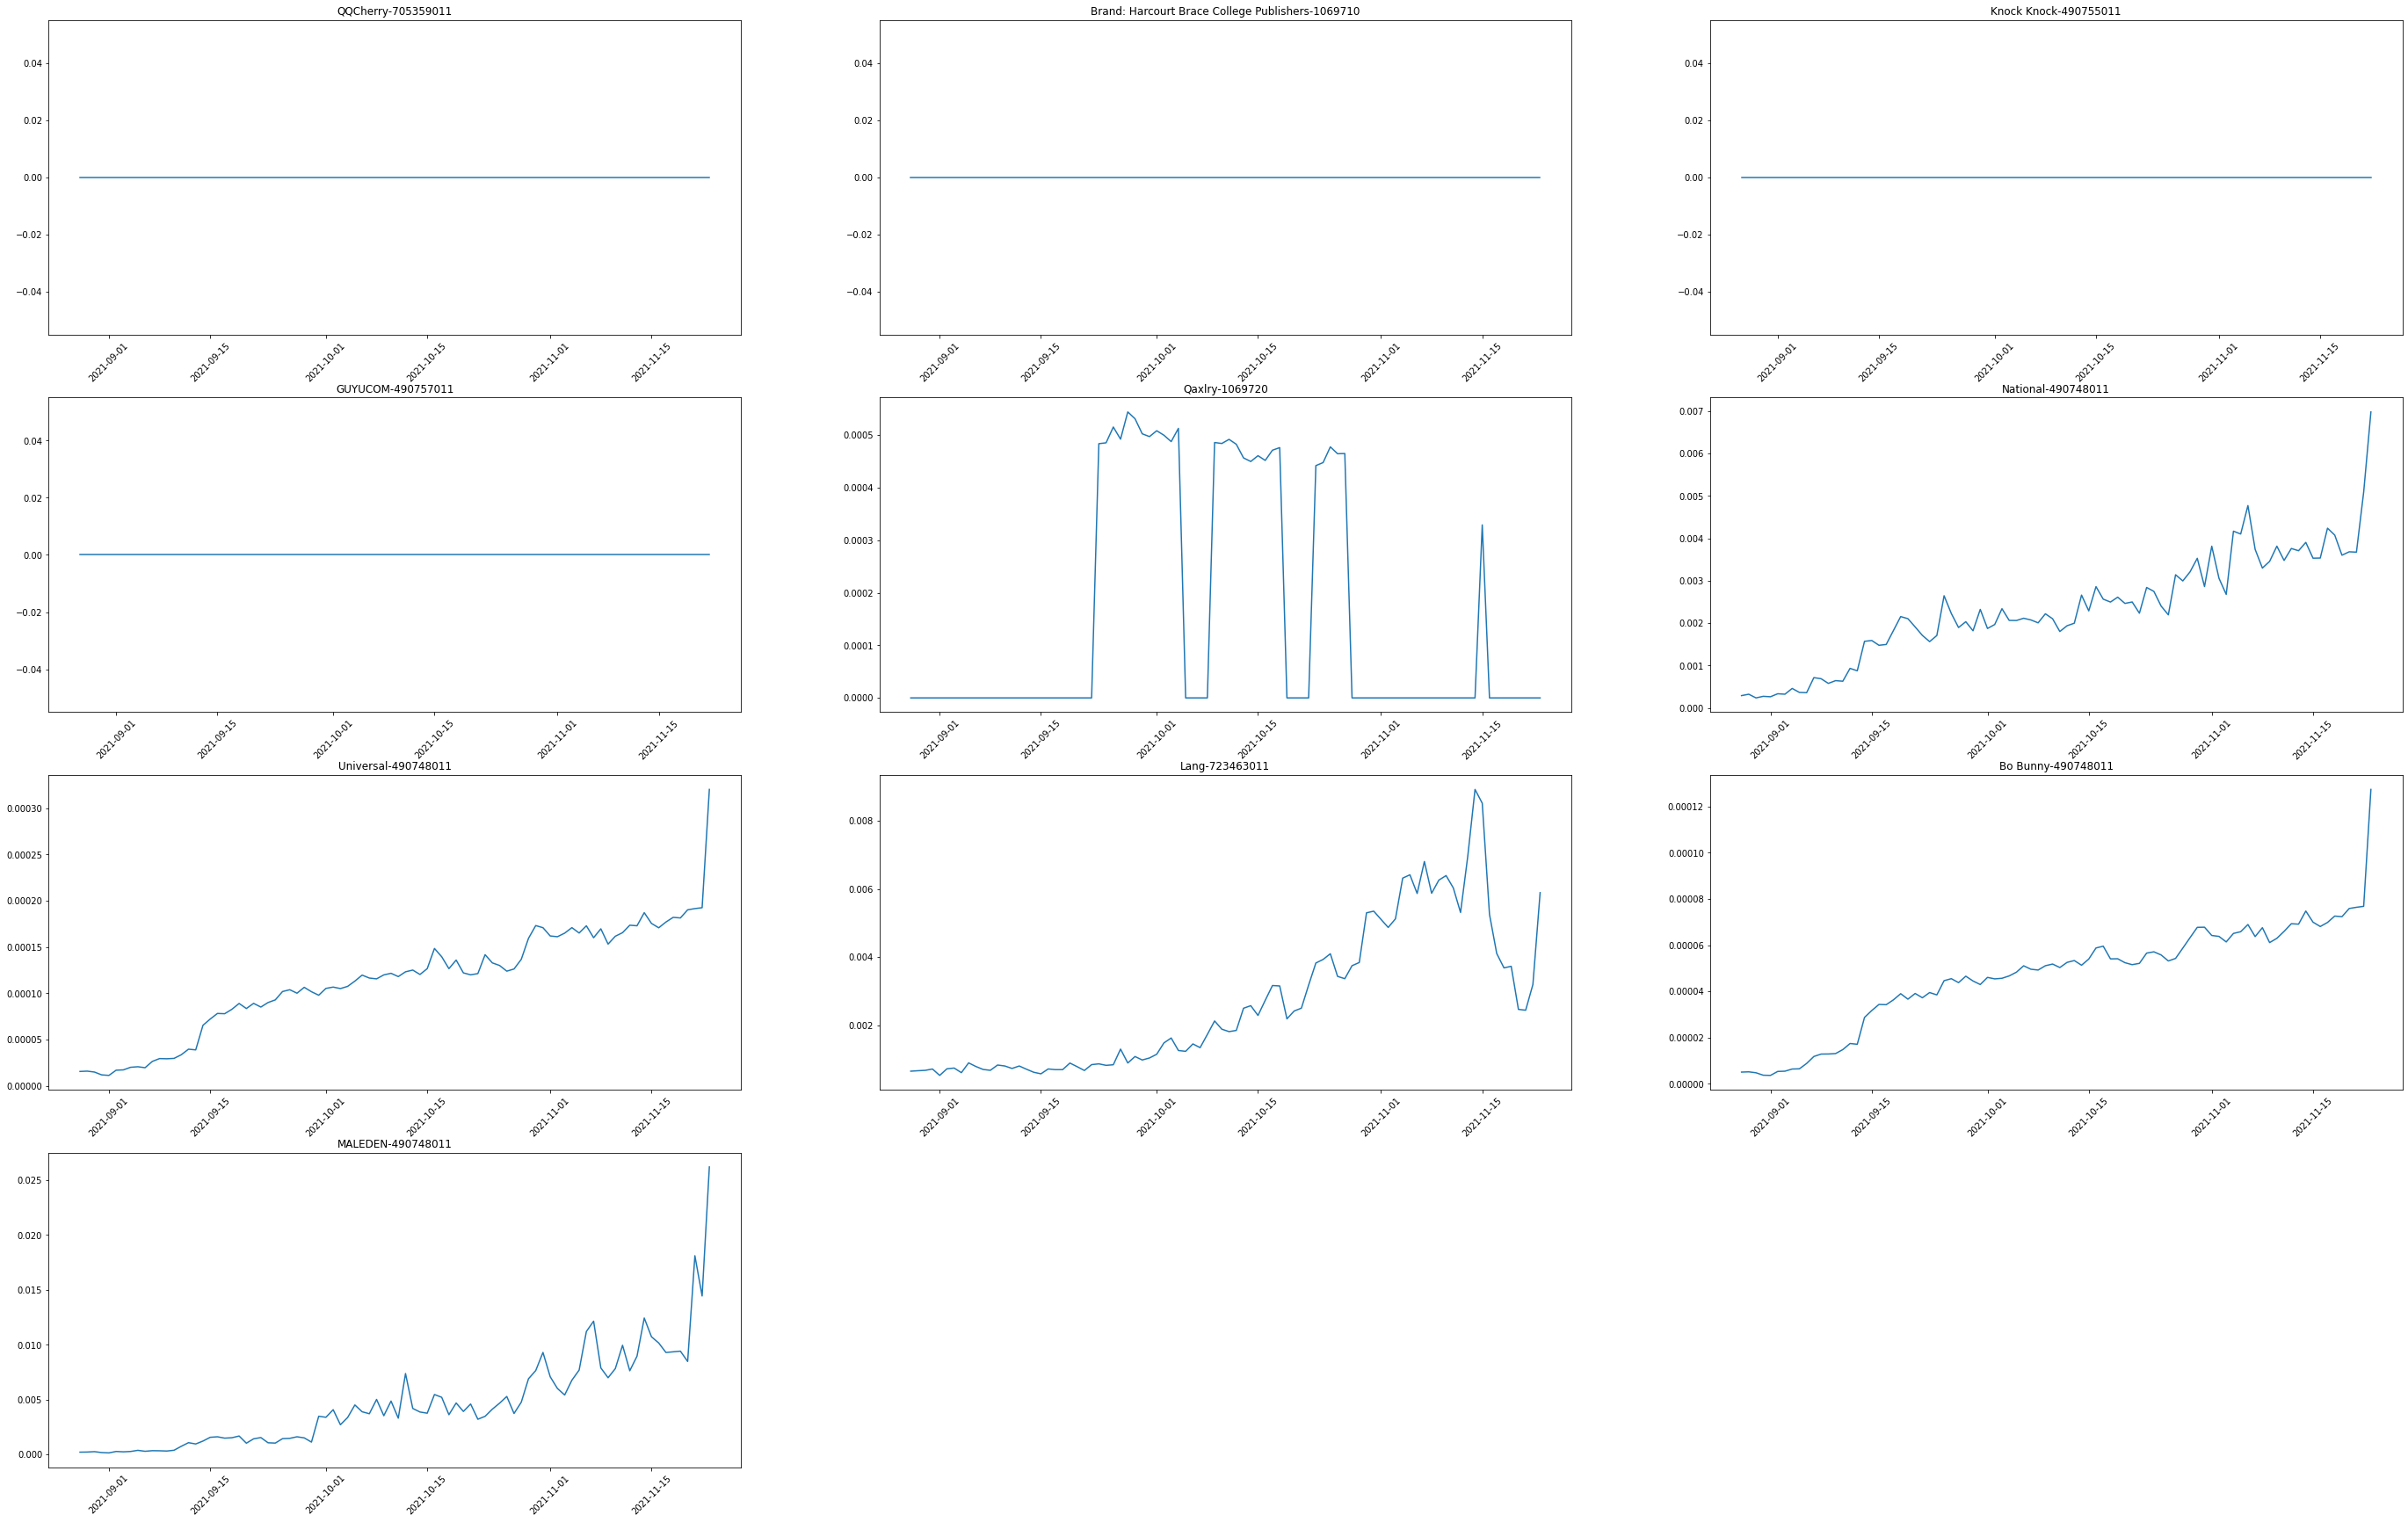

In [ ]:
# Scale should be changed from -1 to 1 instead of 0 to 1


# Function to plot the timeseries data for the given brand categories 
def plot_brand_categories(brand_categories):
  plt.figure(figsize=(48,54))
  for i in range(len(brand_categories)):
    brand = brand_categories[i][0]
    category_id = brand_categories[i][1]
    test = filtered_brand_metrics_daily.loc[(filtered_brand_metrics_daily["brand"].eq(brand)) &(filtered_brand_metrics_daily["category_id"]==category_id), ["sample_date" ,"daily_sales_share"]]  
    test.index = test["sample_date"]
    plt.subplot(7,3, i+1)
    plt.title(f"{brand}-{category_id}")
    plt.plot(test["daily_sales_share"])
    plt.xticks(rotation=45)
  plt.show()


# # Checking the brand-categories which has lowest total growth rate
# print(brand_category_score.loc[brand_category_score['final_growth_rate'].gt(brand_category_score['final_growth_rate'].quantile(.95)),:].sort_values(by="final_growth_rate").head(20))
# brand_categories = [("Domtar",21328370011), ("Kirkland Signature",1069738), ("YANCAI",490748011), ("Paper Papers",1069722), ("Disney Frozen",1069712), ("Carson Dellosa Education",1069664), ("Royal Consumer",1069722),
# ("The Image Shop",1069722), ("Intro-Tech",1069756), ("Compendium",490756011), ("Simple & Basic",1069722), ("Norcom",490748011), ("S Superfine Printing",1069708), ("Habercrafts",1069722), ("Lang",723463011), 
# ("Magnum Magnetics-Corporation",1069722), ("BUYGO",1069722), ("STEELAID",1069760), ("The Nightmare Before Christmas",12900091), ("ivoQLTY",1069722)
# ]

# # Checking the brand-categories which has largest total growth rate
# print(brand_category_score.loc[brand_category_score['final_growth_rate'].gt(brand_category_score['final_growth_rate'].quantile(.95)),:].sort_values(by="final_growth_rate").tail(20))
# brand_categories = [("Yoment",490757011), ("MultiBey",490748011), ("Oneirom",1069756), ("Kem Playing Cards",490741011), ("Oneirom",490757011), ("Elonglin",490748011), ("Stonehouse Collection",723463011), ("Stonehouse Collection",1069666),
# ("Brother",490748011), ("MALEDEN",490748011), ("Hayes Paper Co.",1069724), ("Tonha",21328370011), ("LemoHome",490757011), ("4COU",1069712), ("KEFF",490748011), ("n\\a",490756011), ("KAISA",490764011),
# ("Red Farm Studios",490741011),("Paris Business",1069712),("WAFF",1069782)]

brand_categories = [("QQCherry",705359011), ("Brand: Harcourt Brace College Publishers",1069710), ("Knock Knock",490755011), ("GUYUCOM",490757011), ("Qaxlry",1069720), ("National",490748011), ("Universal",490748011), ("Lang",723463011),
("Bo Bunny",490748011), ("MALEDEN",490748011)]
plot_brand_categories(brand_categories)

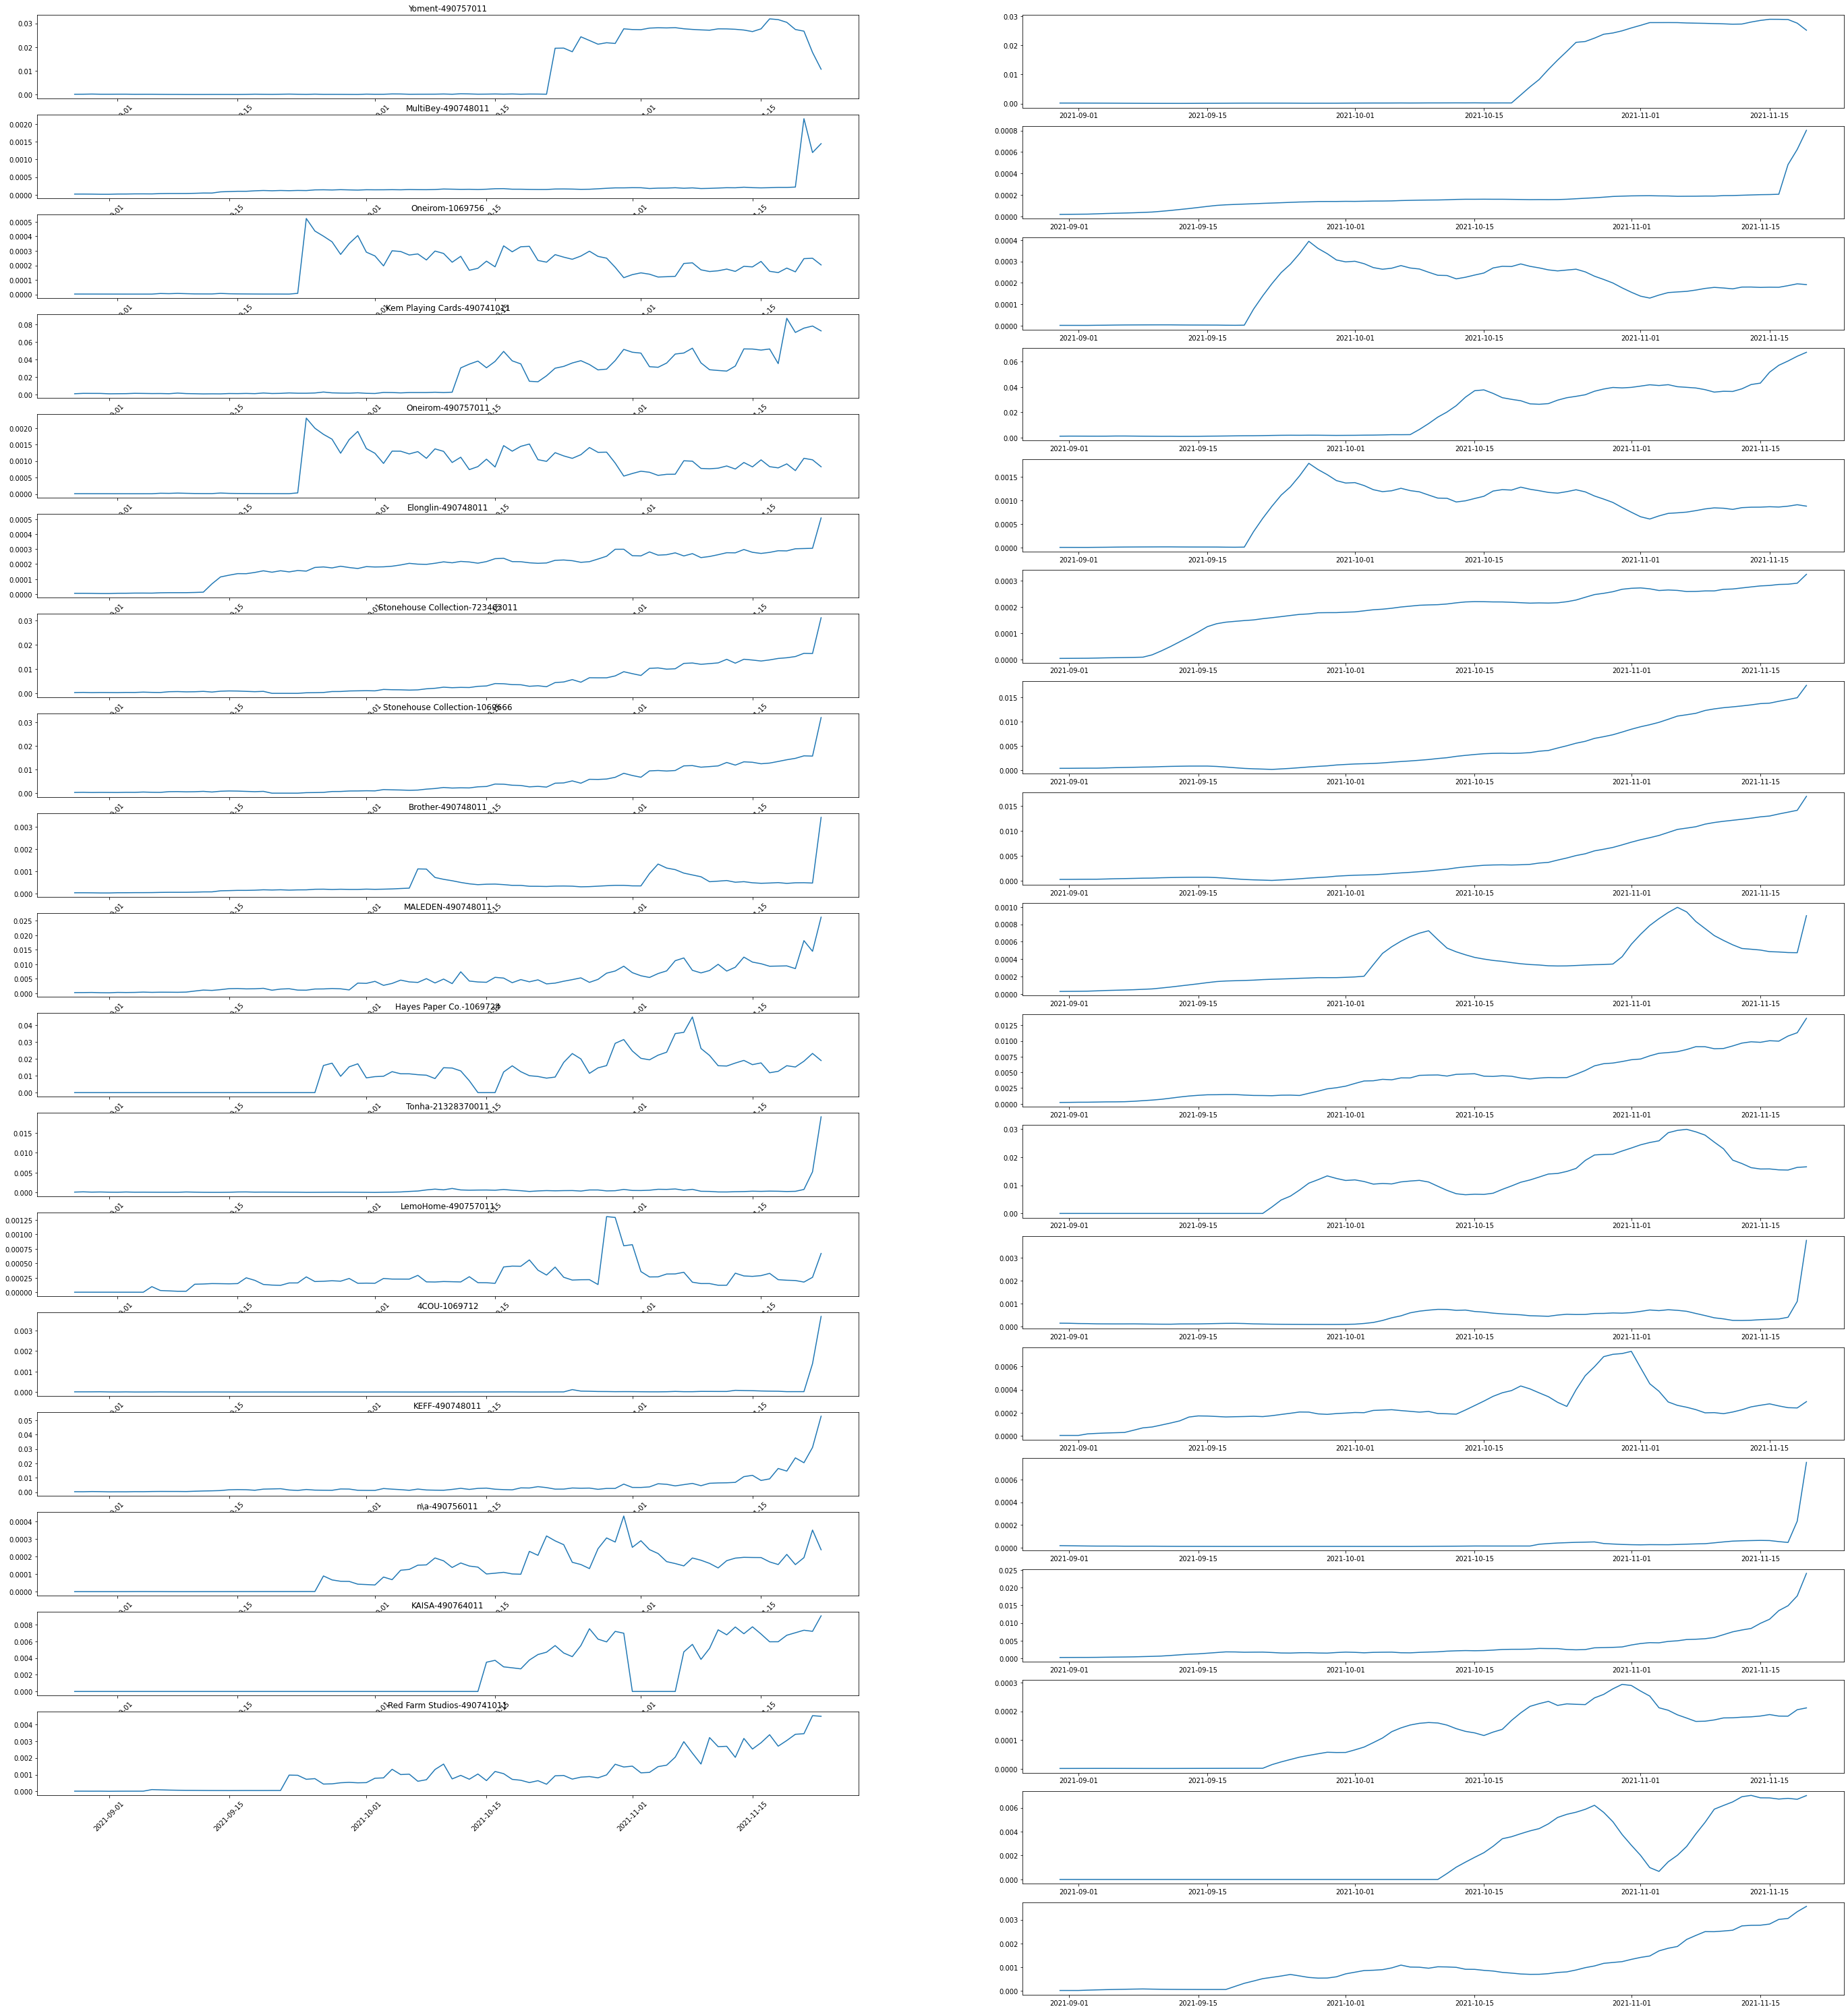

In [ ]:
# Displaying the growth rate and the corresponding trend
brand_categories = [("Yoment",490757011), ("MultiBey",490748011), ("Oneirom",1069756), ("Kem Playing Cards",490741011), ("Oneirom",490757011), ("Elonglin",490748011), ("Stonehouse Collection",723463011), ("Stonehouse Collection",1069666),
("Brother",490748011), ("MALEDEN",490748011), ("Hayes Paper Co.",1069724), ("Tonha",21328370011), ("LemoHome",490757011), ("4COU",1069712), ("KEFF",490748011), ("n\\a",490756011), ("KAISA",490764011),
("Red Farm Studios",490741011)]

plt.figure(figsize=(48,54))
for i in range(len(brand_categories)):
  brand = brand_categories[i][0]
  category_id = brand_categories[i][1]
  test = filtered_brand_metrics_daily.loc[(filtered_brand_metrics_daily["brand"].eq(brand)) &(filtered_brand_metrics_daily["category_id"]==category_id), ["sample_date" ,"daily_sales_share"]]  
  test.index = test["sample_date"]
  result_add = seasonal_decompose(test['daily_sales_share'], model='additive')
  plt.subplot(20, 2, 2*i+1)
  plt.title(f"{brand}-{category_id}")
  plt.plot(test["daily_sales_share"])
  plt.xticks(rotation=45)
  plt.subplot(18, 2, 2*(i+1))
  plt.plot(result_add.trend)
plt.show()

In [ ]:
# checking the mean median difference for the trend component
for i in range(len(brand_categories)):
  brand = brand_categories[i][0]
  category_id = brand_categories[i][1]
  test = filtered_brand_metrics_daily.loc[(filtered_brand_metrics_daily["brand"].eq(brand)) &(filtered_brand_metrics_daily["category_id"]==category_id), ["sample_date" ,"daily_sales_share"]]  
  test.index = test["sample_date"]
  result_add = seasonal_decompose(test['daily_sales_share'], model='additive')
  print(f"{brand}-{category_id}\t\t{result_add.trend.mean()}\t{result_add.trend.median()}\t\t{result_add.trend.mean()-result_add.trend.median()}")
plt.show()

Yoment-490757011		0.009263375815573037	0.00022077596150824286		0.009042599854064795
MultiBey-490748011		0.00015390530416113806	0.0001535280459157857		3.7725824535234857e-07
Oneirom-1069756		0.00017153275086705333	0.00018393953684364998		-1.2406785976596649e-05
Kem Playing Cards-490741011		0.019828014455030504	0.013590262492737313		0.006237751962293191
Oneirom-490757011		0.0007877372320299481	0.0008769103045747953		-8.91730725448472e-05
Elonglin-490748011		0.00018290042626939722	0.00020887893898257856		-2.5978512713181333e-05
Stonehouse Collection-723463011		0.0045384647939401244	0.0022692522963408497		0.0022692124975992748
Stonehouse Collection-1069666		0.004226303981267534	0.0020998740752727852		0.002126429905994749
Brother-490748011		0.0003621155686331268	0.0003360123572185928		2.6103211414533968e-05
MALEDEN-490748011		0.004358501815851561	0.004124194566644335		0.0002343072492072256
Hayes Paper Co.-1069724		0.010874456887003118	0.011123021294417406		-0.0002485644074142878
Tonha-21328

In [ ]:
# Computing the weightage for each category to arrive at the final score for the brand
# Category with more sales is given higher weightage

category_weightage = brand_metrics_daily.groupby(by=["brand", "category_id"])["daily_sales_share"].sum().reset_index()
category_weightage.loc[:,"weightage"] = category_weightage.groupby(by=["brand"])["daily_sales_share"].transform(lambda x:x/x.sum())
category_weightage.drop(columns=["daily_sales_share"],inplace=True)
category_weightage.head(20)

,brand,category_id,weightage
0,Cambridge,490757011,1.000000
1,"""N/A""",1069672,0.213620
2,"""N/A""",1069704,0.076478
3,"""N/A""",1069720,0.709902
4,"""NA""",1069704,0.125377
5,"""NA""",1069720,0.874623
6,''N/A'',1069668,1.000000
7,(RED),1297015011,1.000000
8,100 GREETINGS,1069664,0.067800
9,100 GREETINGS,1069666,0.448202


##### **Competition level** - Average metrics
Number of other brands that sell products in the same category. This has to be calculated at day level.
> High level tasks
 - Data will have to be sourced by combining products and bi_product_metrics_daily.
 - For each brand identify the products sold on a given date and corresponding categories. Find the brands that sold products from the same category on the same date
 - That would provide us the number of brands that sells products in the same category as a given brand and category for a given date
 - Compute the average competition count for a timeframe

##### **Pricing**

### ***Periodic***
In this list of KPIs, we analyse the period as a whole and come up with an aggregate value for each of the brand for the whole time frame.

---
**KPIs**
  1. Competition (see Shay’s calculations about entropy, ratio to leader/s, amazon selling, pricing levels)
  2. Out of stock rates
  3. Product revenue concentration
  4. Category revenue concentration
---
**Tasks**
 - General
   1. Identify the tables required to gather the information

 - Specfic to metric
   1. Brainstorm on how to quantify the revenue distribution across product/category
---


##### Competition (see Shay’s calculations about entropy, ratio to leader/s, amazon selling, pricing levels)

##### **Out of stock rates**

In [ ]:
# out_of_stock for the whole time frame
# out_of_stocks = pd.merge(product_snapshots, products, on="product_id", how="inner", validate="one_to_one").loc[:,["product_id", "brand","out_of_stock_pct", "out_of_stock_pct_30", "out_of_stock_pct_90"]]
out_of_stocks = pd.merge(product_snapshots, products, on="product_id", how="inner", validate="one_to_one").loc[:,["product_id", "brand","out_of_stock_pct_90"]]
# greater or equal to 0 => -1 indicates no value from API
out_of_stock_score = out_of_stocks.groupby(by="brand")["out_of_stock_pct"].mean().reset_index()
scaler = MinMaxScaler()
out_of_stock_score.insert(len(out_of_stock_score.columns), "out_of_stock_score", scaler.fit_transform(out_of_stock_score[['out_of_stock_pct_90']]))
out_of_stock_score["out_of_stock_score"] = 1- out_of_stock_score["out_of_stock_score"]
out_of_stock_score

In [ ]:
out_of_stock_score.loc[out_of_stock_score["out_of_stock_score"]==out_of_stock_score["out_of_stock_score"].max(),:]

,brand,out_of_stock_pct_90,out_of_stock_score
4042,moonster,-0.25,1.0


##### **Product revenue concentration**
Measure how the total revenue of the brand is distributed across its products. This consists of two parts - 
 - Number of products each brand has
 - How the revenue is distributed across the products

In [ ]:
# Product concenteration metric
# Here we find the median number of products across the time frame for each brand and represent it as a fraction of the total number of products 
brand_product_conc = (brand_metrics_daily.groupby(by="brand")["products"].median()/brand_metrics_daily.groupby(by="brand")["products"].median().sum()).reset_index()
brand_product_conc.sort_values(by="products")

,brand,products
0,Cambridge,0.000129
2416,P&L ART.,0.000129
2418,PAIVSUN,0.000129
2420,PAPERANG,0.000129
2421,PAPERCODE,0.000129
...,...,...
2711,Quiplip,0.006731
2627,Postcard Fair,0.007379
2438,PIXILUV,0.007767
1215,Get Paper,0.008155


In [ ]:
# Product revenue concenteration metric
# Here we find how uniformly the total revenue of the brand is distributed across its different products

# Use total sales of the brands across products and then use that to check how it is distributed

# Merging the product_metrics_daily with products to get the brand information
# validate="many_to_one" ==> Since a the same product_id can be listed multiple time in product_metrics_daily for each sample_date
df = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")

brand_products = df.groupby(by=["brand", "product_id"])["daily_sales"].apply(np.sum).reset_index()
calculate_entropy = lambda x:sc.entropy(x["daily_sales"]/x["daily_sales"].sum()) if x["daily_sales"].sum()!=0 and len(x["daily_sales"])>1 else 1000
brand_product_revenue_entropy = brand_products.groupby(by="brand").apply(calculate_entropy).reset_index()
brand_product_revenue_entropy.rename(columns={0:"product_revenue_entropy"}, inplace=True)
brand_product_revenue_entropy.sort_values(by="product_revenue_entropy")

,brand,product_revenue_entropy
1075,Faux Designs,0.0
3829,amassan,0.0
1177,GSM Brands,0.0
3372,ToucanEd,0.0
2787,Regent,0.0
...,...,...
1725,Konsait,1000.0
1731,Kovot,1000.0
1733,Kpop,1000.0
1608,Joyousa,1000.0


In [ ]:
# Finding the brand with maximum entropy
brand_product_revenue_entropy.loc[brand_product_revenue_entropy["product_revenue_entropy"]!=1000].max()

brand                      モレスキン(Moleskine)
product_revenue_entropy            5.263582
dtype: object

In [ ]:
# # Finding the average sales for each brand-product_id combination across the time frame
# brand_products_sales = df.groupby(by=["brand", "product_id"])["daily_sales"].apply(np.mean).reset_index()
# brand_products_sales

In [ ]:
# Since there is another KPI that represent the category distribution of the brand, including the category information here might not be neccessary

# # Finding the median number of products of each brand in a given category
# category_id = 705354011
# total_no_of_products = brand_metrics_daily.loc[brand_metrics_daily["category_id"].eq(category_id),:].groupby("brand")["products"].median().sum()
# brand_metrics_daily.loc[brand_metrics_daily["category_id"].eq(category_id),:].groupby("brand")["products"].median()/total_no_of_products

In [ ]:
# test = brand_metrics_daily.groupby(by=["brand", "category_id"])["products"].median().reset_index().groupby(by="category_id")["products"].median().reset_index()
# test.rename(columns={"products": "median_products"}, inplace=True)
# test1 = brand_metrics_daily.groupby(by=["brand", "category_id"])["products"].median().reset_index().groupby(by="category_id")["products"].mean().reset_index()
# test1.rename(columns={"products": "mean_products"}, inplace=True)
# test2 = pd.merge(test, test1, on="category_id", how="inner")
# test2

In [ ]:
brand_products = df.groupby(by=["brand", "product_id"])["daily_sales"].apply(np.mean).reset_index()
brand_products.rename(columns={0: "average_sales"}, inplace=True)
# Finding the average number of products for each brand
avg_product_count = brand_products.groupby(by="brand")["product_id"].size().mean()
# Finding the average number of products for each brand
median_product_count = brand_products.groupby(by="brand")["product_id"].size().median()
print("Average: {}, Median: {}".format(avg_product_count, median_product_count))
brand_products

Average: 5.379026217228464, Median: 1.0


,brand,product_id,average_sales
0,Cambridge,B07DXBWL6Q,58.222292
1,"""N/A""",B087R4K8TD,34.253545
2,"""N/A""",B09B9XY1N8,10.527276
3,"""N/A""",B09FGM6YLJ,12.160660
4,"""N/A""",B09KCFDD9L,25.702300
...,...,...,...
21538,モレスキン(Moleskine),B00O80WCSG,4.660038
21539,モレスキン(Moleskine),B00O80WCSQ,4.192505
21540,モレスキン(Moleskine),B00O80WCU4,5.327313
21541,モレスキン(Moleskine),B010UFCAK2,23.536261


In [ ]:
brand_product_revenue_entropy[brand_product_revenue_entropy[0].eq(brand_product_revenue_entropy[0].max()]

,brand,0
1341,Hallmark,5.292199


In [ ]:
brand_product_revenue_cov[brand_product_revenue_cov["average_sales"].isnull()]

,brand,average_sales
436,Brand: Harcourt Brace College Publishers,NaN
635,ColorTrac,NaN
703,Creative Hobbies,NaN
1183,GUYUCOM,NaN
1763,LEICA VINTAGE,NaN
2620,Poppin,NaN
2632,Premier Multipurpose Office Paper,NaN
2692,QQCherry,NaN
2717,RAK TRACK,NaN
2792,Relay,NaN


In [ ]:
brand_products[brand_products["brand"].eq("Hallmark")]

,brand,product_id,average_sales
8128,Hallmark,B01LWQQGMA,60.047469
8129,Hallmark,B01LWQQM82,204.266495
8130,Hallmark,B01LWQQZ1S,78.586424
8131,Hallmark,B01LWQQZQK,40.955505
8132,Hallmark,B01LWQQZWX,97.778248
...,...,...,...
8469,Hallmark,B094YPKSFN,373.566202
8470,Hallmark,B0988C166S,214.806447
8471,Hallmark,B0988RQDF4,73.865574
8472,Hallmark,B0988T57NK,186.523448


##### **Category revenue concentration**

In [ ]:
brand_products.groupby(by="brand").apply(lambda x:x["average_sales"].max()-x["average_sales"].min())

brand
    Cambridge          0.000000
"N/A"                 23.726269
"NA"                   0.000000
''N/A''                0.000000
(RED)                  0.000000
                       ...     
✅ REGISTERROLL         0.000000
✅ RegisterRoll      8228.135297
コクヨ(KOKUYO)           30.816442
モレスキン(Moleskine)      65.214643
不适用                    0.000000
Length: 4005, dtype: float64

In [ ]:
# Product distribution - Number of products for each of the brand
brand_metrics_daily.groupby(by="brand")["products"].median()
# We can not use brand_metrics_daily sincce it just as number of products. It does not have the granularity of the revenue comng from each of the brand
# To get how the revenue is distributed among the different products of the brand, we have to look at the the product metrics

brand
    Cambridge       1.0
"N/A"               1.0
"NA"                1.0
''N/A''             1.0
(RED)               1.0
                   ... 
✅ REGISTERROLL      1.0
✅ RegisterRoll      7.0
コクヨ(KOKUYO)         1.0
モレスキン(Moleskine)    2.0
不适用                 1.0
Name: products, Length: 4005, dtype: float64

In [ ]:
# scaler- = MinMaxScaler()
# product_count_score = scaler.fit_transform(brand_products.groupby(by="brand")["product_id"].size())

### ***Snapshot***
In this list of KPIs, we analyse the data at a given point of time and come up with score that can be used to compare the brands.

---
**KPIs**
  1. Number of Sellers
  2. Brand sells its products not/exclusively
  3. Seller reviews (count/score)
  4. Product reviews
  5. Pricing
---
**Tasks**
 - General
   1. TODO

 - Specfic to metric
   1. TODO
---

##### Number of Sellers

##### Brand sells its products not/exclusively

##### Reseller sells the brand’s products not/exclusively

##### Seller reviews (count/score)

In [ ]:
Relook at the daily change in review count and review score

Pricing - Time series analysis needs to be done at product level and the aggregate it for the brand level

brand 1 - 10 product (average of products across total time frame)
brand 2 - 1 product (average of products across total time frame)
brand 3 - 5 product (average of products across total time frame)

median of 10,1,5 to get the 
then to get the score we didvide by median

brand 1 - 10/16
brand 2 - 1/16

In [ ]:
Num of Products score	Sales shares of products score	Total score(addition)	Total score (multiplication)
0.571428571	0.5	1.071428571	0.285714286
1.142857143	1	2.142857143	1.142857143
0.571428571	1	1.571428571	0.571428571
1.142857143	0.5	1.642857143	0.571428571